In [12]:
%pip install -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
# layers × models × precision for participancy ratio of given refusal direction calculed w diff o' means
# PR = 1 means all variance in 1 dimension, PR = n means spread across n dimensions

import torch
import numpy as np
import requests
import pandas as pd
import io
import gc
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from huggingface_hub import login as hf_login
import os
from dotenv import load_dotenv

load_dotenv()
hf_login(token=os.environ.get('HF_TOKEN'))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [14]:
DEVICE = 'cuda'
LLAMA_PATH = 'meta-llama/Llama-2-7b-chat-hf'
LAT_PATH = 'nlpett/llama-2-7b-chat-hf-LAT-layer4-hh'
AT_PATH = 'nlpett/llama-2-7b-chat-hf-AT-hh'
TEMPLATE = '\n[INST]{prompt}[/INST]\n'

LAYERS = [4, 8, 12, 14, 16, 20]  # incl. LAT perturbation layer (4) and best ablation layer (14)
# Use string keys - 8bit not supported by TransformerLens, so test 4bit variants + higher precision
PRECISIONS = ['4bit-nf4', '4bit-nf4-no-dq', '4bit-fp4', '4bit-nf4-fp32compute', 'bf16', 'fp16', 'fp32']
MODELS = [('BASE', None), ('AT', AT_PATH), ('LAT', LAT_PATH)]
N = 416


In [15]:
# precision configs - each returns (quantization_config or None, dtype, name)
PRECISION_CONFIGS = {
    '4bit-nf4': {
        'quant_config': BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16,
                                           bnb_4bit_use_double_quant=True, bnb_4bit_quant_type='nf4'),
        'dtype': torch.float16, 'name': '4bit-nf4'
    },
    '4bit-nf4-no-dq': {
        'quant_config': BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16,
                                           bnb_4bit_use_double_quant=False, bnb_4bit_quant_type='nf4'),
        'dtype': torch.float16, 'name': '4bit-nf4-no-dq'
    },
    '4bit-fp4': {
        'quant_config': BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16,
                                           bnb_4bit_use_double_quant=True, bnb_4bit_quant_type='fp4'),
        'dtype': torch.float16, 'name': '4bit-fp4'
    },
    '4bit-nf4-fp32compute': {
        'quant_config': BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float32,
                                           bnb_4bit_use_double_quant=True, bnb_4bit_quant_type='nf4'),
        'dtype': torch.float32, 'name': '4bit-nf4-fp32'
    },
    'bf16': {'quant_config': None, 'dtype': torch.bfloat16, 'name': 'bf16'},
    'fp16': {'quant_config': None, 'dtype': torch.float16, 'name': 'fp16'},
    'fp32': {'quant_config': None, 'dtype': torch.float32, 'name': 'fp32'},
}

def get_precision_config(key):
    if key not in PRECISION_CONFIGS:
        raise ValueError(f'Unknown precision: {key}')
    cfg = PRECISION_CONFIGS[key]
    return cfg['quant_config'], cfg['dtype'], cfg['name']

def clear_gpu():
    gc.collect(); torch.cuda.empty_cache(); torch.cuda.synchronize()

def load_model(peft_path, quant_config, dtype):
    kwargs = {'torch_dtype': dtype, 'device_map': 'auto'}
    if quant_config: kwargs['quantization_config'] = quant_config
    base = AutoModelForCausalLM.from_pretrained(LLAMA_PATH, **kwargs)
    if peft_path:
        peft = PeftModel.from_pretrained(base, peft_path)
        if not quant_config: peft = peft.to(dtype)
        hf_model = peft.merge_and_unload(); hf_model.eval(); del peft
    else:
        hf_model = base
    hooked = HookedTransformer.from_pretrained_no_processing(
        LLAMA_PATH, hf_model=hf_model, dtype=dtype, device=DEVICE, default_padding_side='left')
    hooked.tokenizer.padding_side = 'left'; hooked.tokenizer.pad_token = '[PAD]'
    del base; clear_gpu()
    return hooked

def get_acts_multi_layer(model, instructions, layers, batch_size=16):
    acts = {l: [] for l in layers}
    for i in tqdm(range(0, len(instructions), batch_size)):
        prompts = [TEMPLATE.format(prompt=p) for p in instructions[i:i+batch_size]]
        toks = model.tokenizer(prompts, padding=True, return_tensors='pt').input_ids.to(DEVICE)
        with torch.no_grad():
            _, cache = model.run_with_cache(toks, names_filter=lambda n: 'resid_pre' in n)
        for l in layers:
            acts[l].append(cache['resid_pre', l][:, -1, :].cpu())
        del cache
    return {l: torch.cat(a, dim=0) for l, a in acts.items()}

def participation_ratio(diffs):
    diffs = diffs.float()
    cov = (diffs.T @ diffs) / len(diffs)
    eigs = torch.linalg.eigvalsh(cov)
    eigs = eigs[eigs > 1e-10]
    return (eigs.sum() ** 2 / (eigs ** 2).sum()).item()


In [16]:
url = 'https://raw.githubusercontent.com/llm-attacks/llm-attacks/main/data/advbench/harmful_behaviors.csv'
harmful_train, _ = train_test_split(pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))['goal'].tolist(), 
                                     test_size=0.2, random_state=42)
dataset = load_dataset('tatsu-lab/alpaca')
harmless_all = [dataset['train'][i]['instruction'] for i in range(len(dataset['train'])) if dataset['train'][i]['input'].strip() == '']
harmless_train, _ = train_test_split(harmless_all, test_size=0.2, random_state=42)
print(f'Loaded {len(harmful_train)} harmful, {len(harmless_train)} harmless')


Loaded 416 harmful, 25058 harmless


In [17]:
# main loop: precision -> model -> layers
results = {}  # results[prec_key][model_name][layer] = PR value

for prec_key in PRECISIONS:
    quant_config, dtype, prec_name = get_precision_config(prec_key)
    results[prec_key] = {}
    print(f'{prec_name.upper()}')
    
    for model_name, peft_path in MODELS:
        print(f'\n{model_name}:')
        results[prec_key][model_name] = {}
        
        try:
            model = load_model(peft_path, quant_config, dtype)
            harmful_acts = get_acts_multi_layer(model, harmful_train[:N], LAYERS)
            harmless_acts = get_acts_multi_layer(model, harmless_train[:N], LAYERS)
            
            for layer in LAYERS:
                diffs = harmful_acts[layer] - harmless_acts[layer]
                pr = participation_ratio(diffs)
                results[prec_key][model_name][layer] = pr
                print(f'  L{layer}: PR={pr:.1f}')
            
            del model, harmful_acts, harmless_acts
            clear_gpu()
        except Exception as e:
            print(f'ERROR: {e}')
            import traceback
            traceback.print_exc()
            clear_gpu()


4BIT-NF4

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:02<00:00, 10.36it/s]


  L4: PR=8.4
  L8: PR=13.6
  L12: PR=6.8
  L14: PR=4.1
  L16: PR=3.3
  L20: PR=4.1

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]
/home/ubuntu/.local/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:02<00:00, 10.22it/s]


  L4: PR=5.5
  L8: PR=13.2
  L12: PR=7.1
  L14: PR=5.2
  L16: PR=3.3
  L20: PR=4.1

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:02<00:00, 10.35it/s]


  L4: PR=1.1
  L8: PR=1.2
  L12: PR=2.2
  L14: PR=3.2
  L16: PR=4.0
  L20: PR=5.2

4BIT-NF4-NO-DQ

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:02<00:00, 12.14it/s]


  L4: PR=8.4
  L8: PR=13.6
  L12: PR=6.8
  L14: PR=4.1
  L16: PR=3.2
  L20: PR=4.1

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:02<00:00, 12.02it/s]


  L4: PR=5.6
  L8: PR=13.2
  L12: PR=7.1
  L14: PR=5.2
  L16: PR=3.3
  L20: PR=4.1

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:02<00:00, 11.96it/s]


  L4: PR=1.1
  L8: PR=1.2
  L12: PR=2.2
  L14: PR=3.3
  L16: PR=4.1
  L20: PR=5.2

4BIT-FP4

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:02<00:00, 10.39it/s]


  L4: PR=5.9
  L8: PR=14.3
  L12: PR=6.8
  L14: PR=3.8
  L16: PR=3.4
  L20: PR=4.3

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:02<00:00, 10.38it/s]


  L4: PR=6.2
  L8: PR=12.1
  L12: PR=6.8
  L14: PR=4.6
  L16: PR=3.1
  L20: PR=4.0

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:02<00:00, 10.28it/s]


  L4: PR=1.2
  L8: PR=1.9
  L12: PR=5.2
  L14: PR=5.0
  L16: PR=4.8
  L20: PR=5.6

4BIT-NF4-FP32

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:05<00:00,  5.12it/s]


  L4: PR=8.4
  L8: PR=13.6
  L12: PR=6.8
  L14: PR=4.1
  L16: PR=3.3
  L20: PR=4.1

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:05<00:00,  5.11it/s]


  L4: PR=5.5
  L8: PR=13.2
  L12: PR=7.1
  L14: PR=5.2
  L16: PR=3.3
  L20: PR=4.1

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:05<00:00,  5.11it/s]


  L4: PR=1.1
  L8: PR=1.2
  L12: PR=2.2
  L14: PR=3.2
  L16: PR=4.0
  L20: PR=5.2

BF16

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:01<00:00, 15.77it/s]


  L4: PR=8.3
  L8: PR=13.3
  L12: PR=6.1
  L14: PR=3.8
  L16: PR=2.9
  L20: PR=3.9

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:01<00:00, 15.80it/s]


  L4: PR=6.5
  L8: PR=16.2
  L12: PR=8.8
  L14: PR=6.8
  L16: PR=4.2
  L20: PR=4.7

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:01<00:00, 15.78it/s]


  L4: PR=1.0
  L8: PR=1.0
  L12: PR=1.0
  L14: PR=1.0
  L16: PR=1.0
  L20: PR=1.0

FP16

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:01<00:00, 15.85it/s]


  L4: PR=8.3
  L8: PR=13.3
  L12: PR=6.1
  L14: PR=3.8
  L16: PR=2.9
  L20: PR=3.9

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:01<00:00, 15.85it/s]


  L4: PR=6.5
  L8: PR=16.2
  L12: PR=8.8
  L14: PR=6.8
  L16: PR=4.2
  L20: PR=4.7

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:01<00:00, 15.83it/s]


  L4: PR=1.0
  L8: PR=1.0
  L12: PR=1.0
  L14: PR=1.0
  L16: PR=1.0
  L20: PR=1.0

FP32

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:05<00:00,  4.78it/s]


  L4: PR=8.3
  L8: PR=13.3
  L12: PR=6.1
  L14: PR=3.8
  L16: PR=2.9
  L20: PR=3.9

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:05<00:00,  4.78it/s]


  L4: PR=6.5
  L8: PR=16.2
  L12: PR=8.8
  L14: PR=6.8
  L16: PR=4.2
  L20: PR=4.7

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


100%|██████████| 26/26 [00:05<00:00,  4.79it/s]


  L4: PR=1.0
  L8: PR=1.0
  L12: PR=1.0
  L14: PR=1.0
  L16: PR=1.0
  L20: PR=1.0


In [18]:
print('\nParticipation Ratio (effective dimensions) at Layer 14:')
print(f"{'Precision':<20} {'BASE':>8} {'AT':>8} {'LAT':>8}")
for prec_key in PRECISIONS:
    _, _, prec_name = get_precision_config(prec_key)
    row = f"{prec_name:<20}"
    for m in ['BASE', 'AT', 'LAT']:
        val = results[prec_key].get(m, {}).get(14, None)
        row += f"{val:>8.1f}" if val else f"{'N/A':>8}"
    print(row)


Participation Ratio (effective dimensions) at Layer 14:
Precision                BASE       AT      LAT
4bit-nf4                 4.1     5.2     3.2
4bit-nf4-no-dq           4.1     5.2     3.3
4bit-fp4                 3.8     4.6     5.0
4bit-nf4-fp32            4.1     5.2     3.2
bf16                     3.8     6.8     1.0
fp16                     3.8     6.8     1.0
fp32                     3.8     6.8     1.0


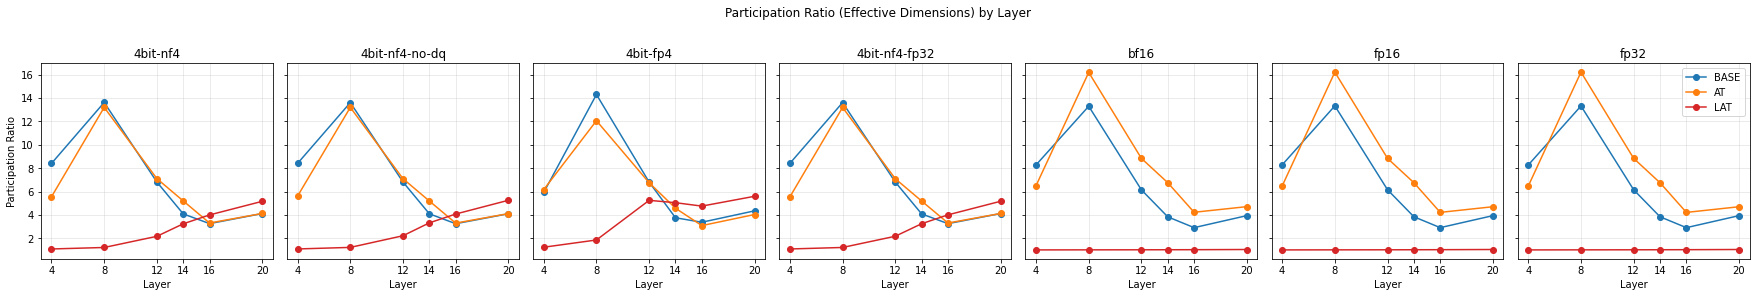

In [19]:
# plot: PR across layers for each model, faceted by precision
fig, axes = plt.subplots(1, len(PRECISIONS), figsize=(3.5*len(PRECISIONS), 4), sharey=True, facecolor='white')
colors = {'BASE': 'tab:blue', 'AT': 'tab:orange', 'LAT': 'tab:red'}

for ax, prec_key in zip(axes, PRECISIONS):
    ax.set_facecolor('white')
    _, _, prec_name = get_precision_config(prec_key)
    for model_name in ['BASE', 'AT', 'LAT']:
        if model_name in results[prec_key]:
            prs = [results[prec_key][model_name].get(l, np.nan) for l in LAYERS]
            ax.plot(LAYERS, prs, 'o-', label=model_name, color=colors[model_name])
    ax.set_xlabel('Layer')
    ax.set_title(prec_name)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(LAYERS)

axes[0].set_ylabel('Participation Ratio')
axes[-1].legend()
fig.suptitle('Participation Ratio (Effective Dimensions) by Layer', y=1.02)
plt.tight_layout()
plt.show()

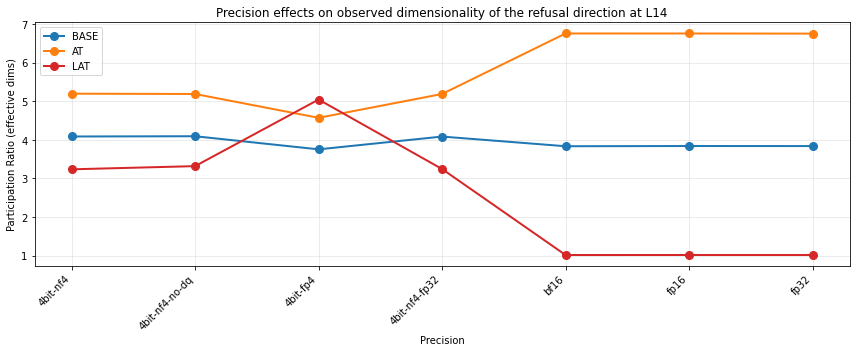

In [20]:
# plot: PR at layer 14 vs precision
fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')
ax.set_facecolor('white')
prec_labels = [get_precision_config(p)[2] for p in PRECISIONS]

for model_name in ['BASE', 'AT', 'LAT']:
    prs = [results[p].get(model_name, {}).get(14, np.nan) for p in PRECISIONS]
    ax.plot(prec_labels, prs, 'o-', label=model_name, color=colors[model_name], linewidth=2, markersize=8)

ax.set_xlabel('Precision')
ax.set_ylabel('Participation Ratio (effective dims)')
ax.set_title('Precision effects on observed dimensionality of the refusal direction at L14')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()